In [1]:
import random
import csv
import os
import pickle

import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from matplotlib import pyplot as plt
import sys

from tqdm import tqdm

from utils.misc.misc import shuffle_lists_by_group
from utils.training.metrics import accuracy_for_segmenter, AUC_for_segmenter
from utils.training.data_loading import get_line_to_dataset_waveform
from utils.training.keras_models import get_phasenet_model

2023-12-04 17:38:41.420556: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 17:38:41.461101: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 17:38:41.461135: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 17:38:41.461164: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 17:38:41.468505: I tensorflow/core/platform/cpu_feature_g

In [2]:
ROOT_DIR = "/media/plerolland/LaBoite/PublicData/training/waveforms"
SEED = 0
BATCH_SIZE = 32
EPOCHS = 50
CHECKPOINTS_DIR = "checkpoints_seg_waveforms"

FOLDS = 5
SIZE = int(2**(np.ceil(np.log2(100*240+1))))  # number of points in each file rounded to the next pow of 2
DURATION_S = 100  # duration of the files in s
OBJECTIVE_CURVE_WIDTH = 10  # defines dispersion of objective function in s

data_loader = get_line_to_dataset_waveform(size=SIZE, duration_s=DURATION_S, objective_curve_width=OBJECTIVE_CURVE_WIDTH)
model = get_phasenet_model(SIZE)

In [3]:
# open the csv listing data, shuffling the lines
with open(ROOT_DIR + "/dataset.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    lines = list(csv_reader)
random.Random(SEED).shuffle(lines)
print(len(lines), "files found")

TO_KEEP = 500

# load data
pos = [l for l in lines if l[1]=="positive"][:TO_KEEP]
xpos, ypos = data_loader(pos)
neg = [l for l in lines if l[1]=="negative"][:TO_KEEP]
xneg, yneg = data_loader(neg)
del pos, neg
print(f"{len(xpos)} positive files found and {len(xneg)} negative files found")

# merge and shuffle positives and negatives
xd = np.concatenate((xpos, xneg[:len(xpos)]))
extra_x = xneg[len(xpos):]
del xneg, xpos
yd = np.concatenate((ypos, yneg[:len(ypos)]))
extra_y = yneg[len(ypos):]
del yneg, ypos
shuffle_lists_by_group([(xd, yd)], SEED)

33919 files found


100%|██████████| 500/500 [00:01<00:00, 485.70it/s]


500 positive files found and 500 negative files found


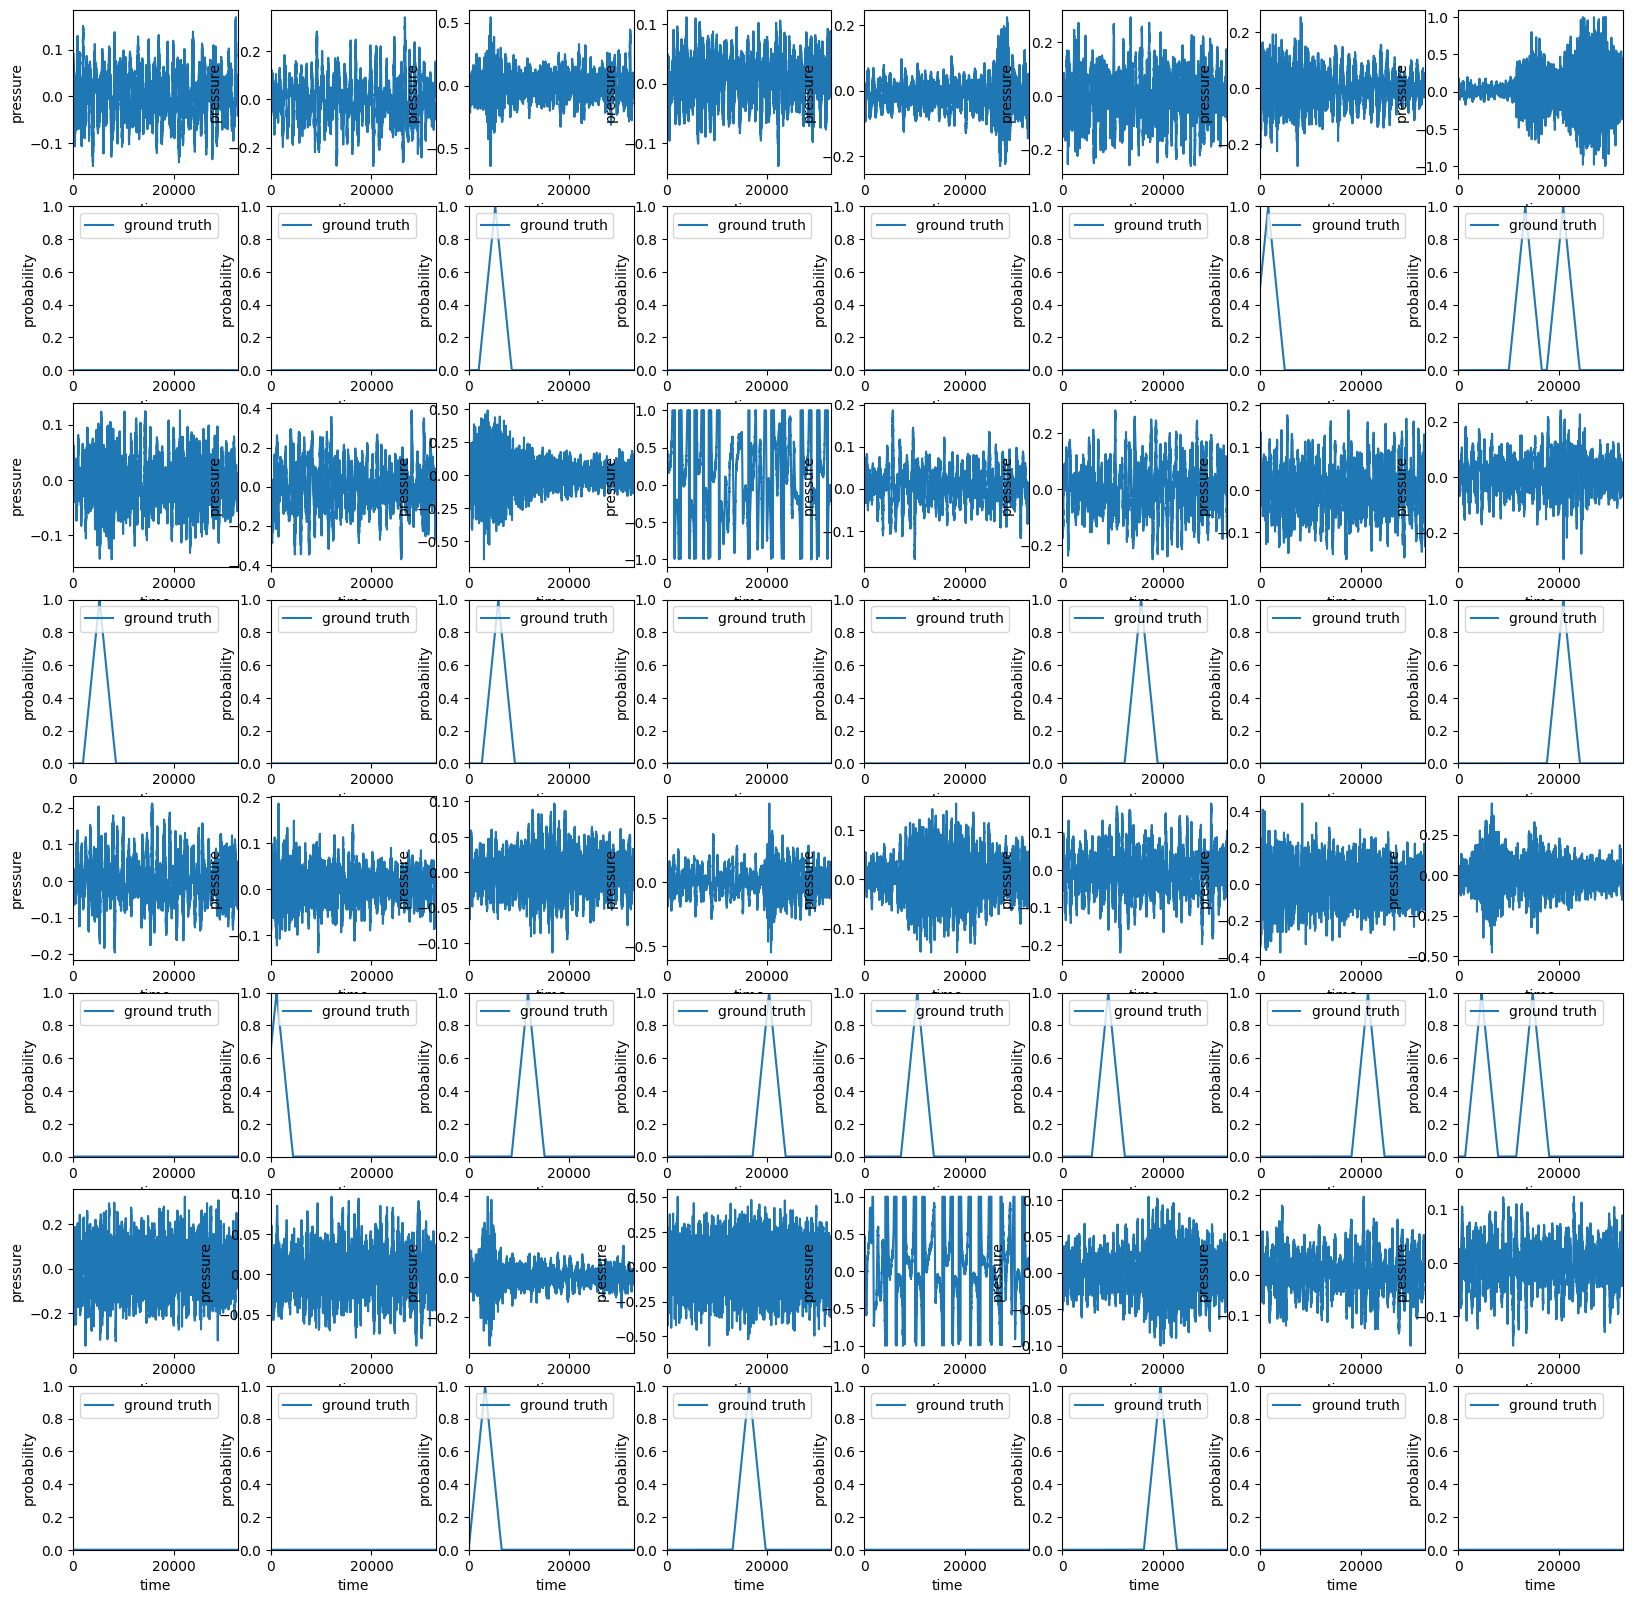

In [4]:
cols = 8
lines = 4
to_skip = 0

to_show = cols * lines
to_skip *= to_show
plt.figure(figsize=(cols*2.5, lines*5))
shown=0
for i in range(to_skip, to_skip+to_show):
    x, y = xd[i], yd[i]
    
    ax1 = plt.subplot(lines*2, cols, 1 + shown%cols + cols*2*(shown//cols))
    plt.xlabel("time")
    plt.ylabel("pressure")
    plt.plot(x)
    ax1.set_xlim([0, SIZE])

    ax2 = plt.subplot(lines*2, cols, 1 + shown%cols + cols*2*(shown//cols) + cols)

    ax2.plot(y, label='ground truth')
    ax2.legend(loc="upper left")
    ax2.set_xlim([0, SIZE])
    ax2.set_ylim([0, 1])
    ax2.set_xlabel("time")
    ax2.set_ylabel("probability")

    shown += 1
plt.show()

In [7]:
for i in range(FOLDS):
    path_prefix = f'{CHECKPOINTS_DIR}/FOLD-{i}'
    history_file = f'{path_prefix}/history.pkl'
    
    if os.path.isfile(history_file):
        print(f"fold {i} already has an history file, skipping it")
        continue
        
    print(f"starting training of fold {i}")
    m = model()
    m.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss=tf.losses.binary_crossentropy,
            metrics=[accuracy_for_segmenter, AUC_for_segmenter()])
    m.build((BATCH_SIZE, SIZE))

    if i==0:
        m.summary()

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{path_prefix}/cp-{{epoch:04d}}.ckpt', save_weights_only=True, verbose=1)

    # make fold
    start_valid_idx = int(len(xd) * i / FOLDS)
    end_valid_idx = int(len(xd) * (i + 1) / FOLDS)
    
    x_train = np.concatenate((xd[:start_valid_idx], xd[end_valid_idx:]))
    y_train = np.concatenate((yd[:start_valid_idx], yd[end_valid_idx:]))
    
    x_valid = xd[start_valid_idx:end_valid_idx]
    y_valid = yd[start_valid_idx:end_valid_idx]
    
    shuffle_lists_by_group([(x_train, y_train), (x_valid, y_valid)], SEED)
    y_train = np.reshape(y_train, (-1, SIZE))
    y_valid = np.reshape(y_valid, (-1, SIZE))

    history = m.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            validation_data=(x_valid,y_valid),
            epochs=EPOCHS,
            callbacks=[cp_callback]
        )
    
    with open(history_file, 'wb') as f:
        pickle.dump(history.history, f)

starting training of fold 0
Model: "phasenet_like"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32768)]              0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 32768, 1)             0         ['input_2[0][0]']             
                                                                                                  
 conv1d_21 (Conv1D)          (None, 32768, 8)             64        ['reshape_1[0][0]']           
                                                                                                  
 conv1d_22 (Conv1D)          (None, 32768, 8)             456       ['conv1d_21[0][0]']           
                                                          

2023-11-24 15:35:36.016895: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 15:35:36.679527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-24 15:35:37.339535: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-24 15:35:41.092618: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5e087fe820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-24 15:35:41.092658: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA T600 Laptop GPU, Compute Capability 7.5
2023-11-24 15:35:41.099678: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-24 15:35:41.223588: I ./tensorflow/compiler/jit/device_compi

25/25 [==============================] - ETA: 0s - loss: 0.6621 - accuracy_for_segmenter: 0.5025 - auc_for_segmenter: 0.5037
Epoch 1: saving model to checkpoints_seg_waveforms/FOLD-0/cp-0001.ckpt
25/25 [==============================] - 22s 232ms/step - loss: 0.6621 - accuracy_for_segmenter: 0.5025 - auc_for_segmenter: 0.5037 - val_loss: 0.6185 - val_accuracy_for_segmenter: 0.5100 - val_auc_for_segmenter: 0.5752
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.5208 - accuracy_for_segmenter: 0.4975 - auc_for_segmenter: 0.5266
Epoch 2: saving model to checkpoints_seg_waveforms/FOLD-0/cp-0002.ckpt
25/25 [==============================] - 4s 159ms/step - loss: 0.5208 - accuracy_for_segmenter: 0.4975 - auc_for_segmenter: 0.5266 - val_loss: 0.2738 - val_accuracy_for_segmenter: 0.5100 - val_auc_for_segmenter: 0.5779
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.2644 - accuracy_for_segmenter: 0.4975 - auc_for_segmenter: 0.5374
Epoch 3: saving model 


KeyboardInterrupt



In [8]:
all_train_x, all_train_y = np.concatenate((xd, extra_x)), np.concatenate((yd, extra_y))
shuffle_lists_by_group([(all_train_x, all_train_y)], 0)

m = model()

m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss=tf.losses.binary_crossentropy,
        metrics=[accuracy_for_segmenter, AUC_for_segmenter()])

m.build((BATCH_SIZE, SIZE))

m.summary()

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{CHECKPOINTS_DIR}/cp-{{epoch:04d}}.ckpt",
                                                     save_weights_only=True,
                                                     verbose=1)



m.fit(
        all_train_x, all_train_y,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[cp_callback]
    )

Model: "phasenet_like"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32768)]              0         []                            
                                                                                                  
 reshape_1 (Reshape)         (None, 32768, 1)             0         ['input_2[0][0]']             
                                                                                                  
 conv1d_21 (Conv1D)          (None, 32768, 8)             64        ['reshape_1[0][0]']           
                                                                                                  
 conv1d_22 (Conv1D)          (None, 32768, 8)             456       ['conv1d_21[0][0]']           
                                                                                      


KeyboardInterrupt



In [4]:
m = model()

#m.load_weights(f"{CHECKPOINTS_DIR}/FOLD-0/cp-0020.ckpt")
m.load_weights("/media/plerolland/LaBoite/PublicData/trainings/checkpoints_auc_acc/checkpoints_seg_waveforms/all/cp-0020.ckpt")

2023-12-04 17:39:36.894279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 17:39:36.913251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 17:39:36.913395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-12-04 17:39:40.532198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-04 17:39:40.852215: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-04 17:39:40.921234: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


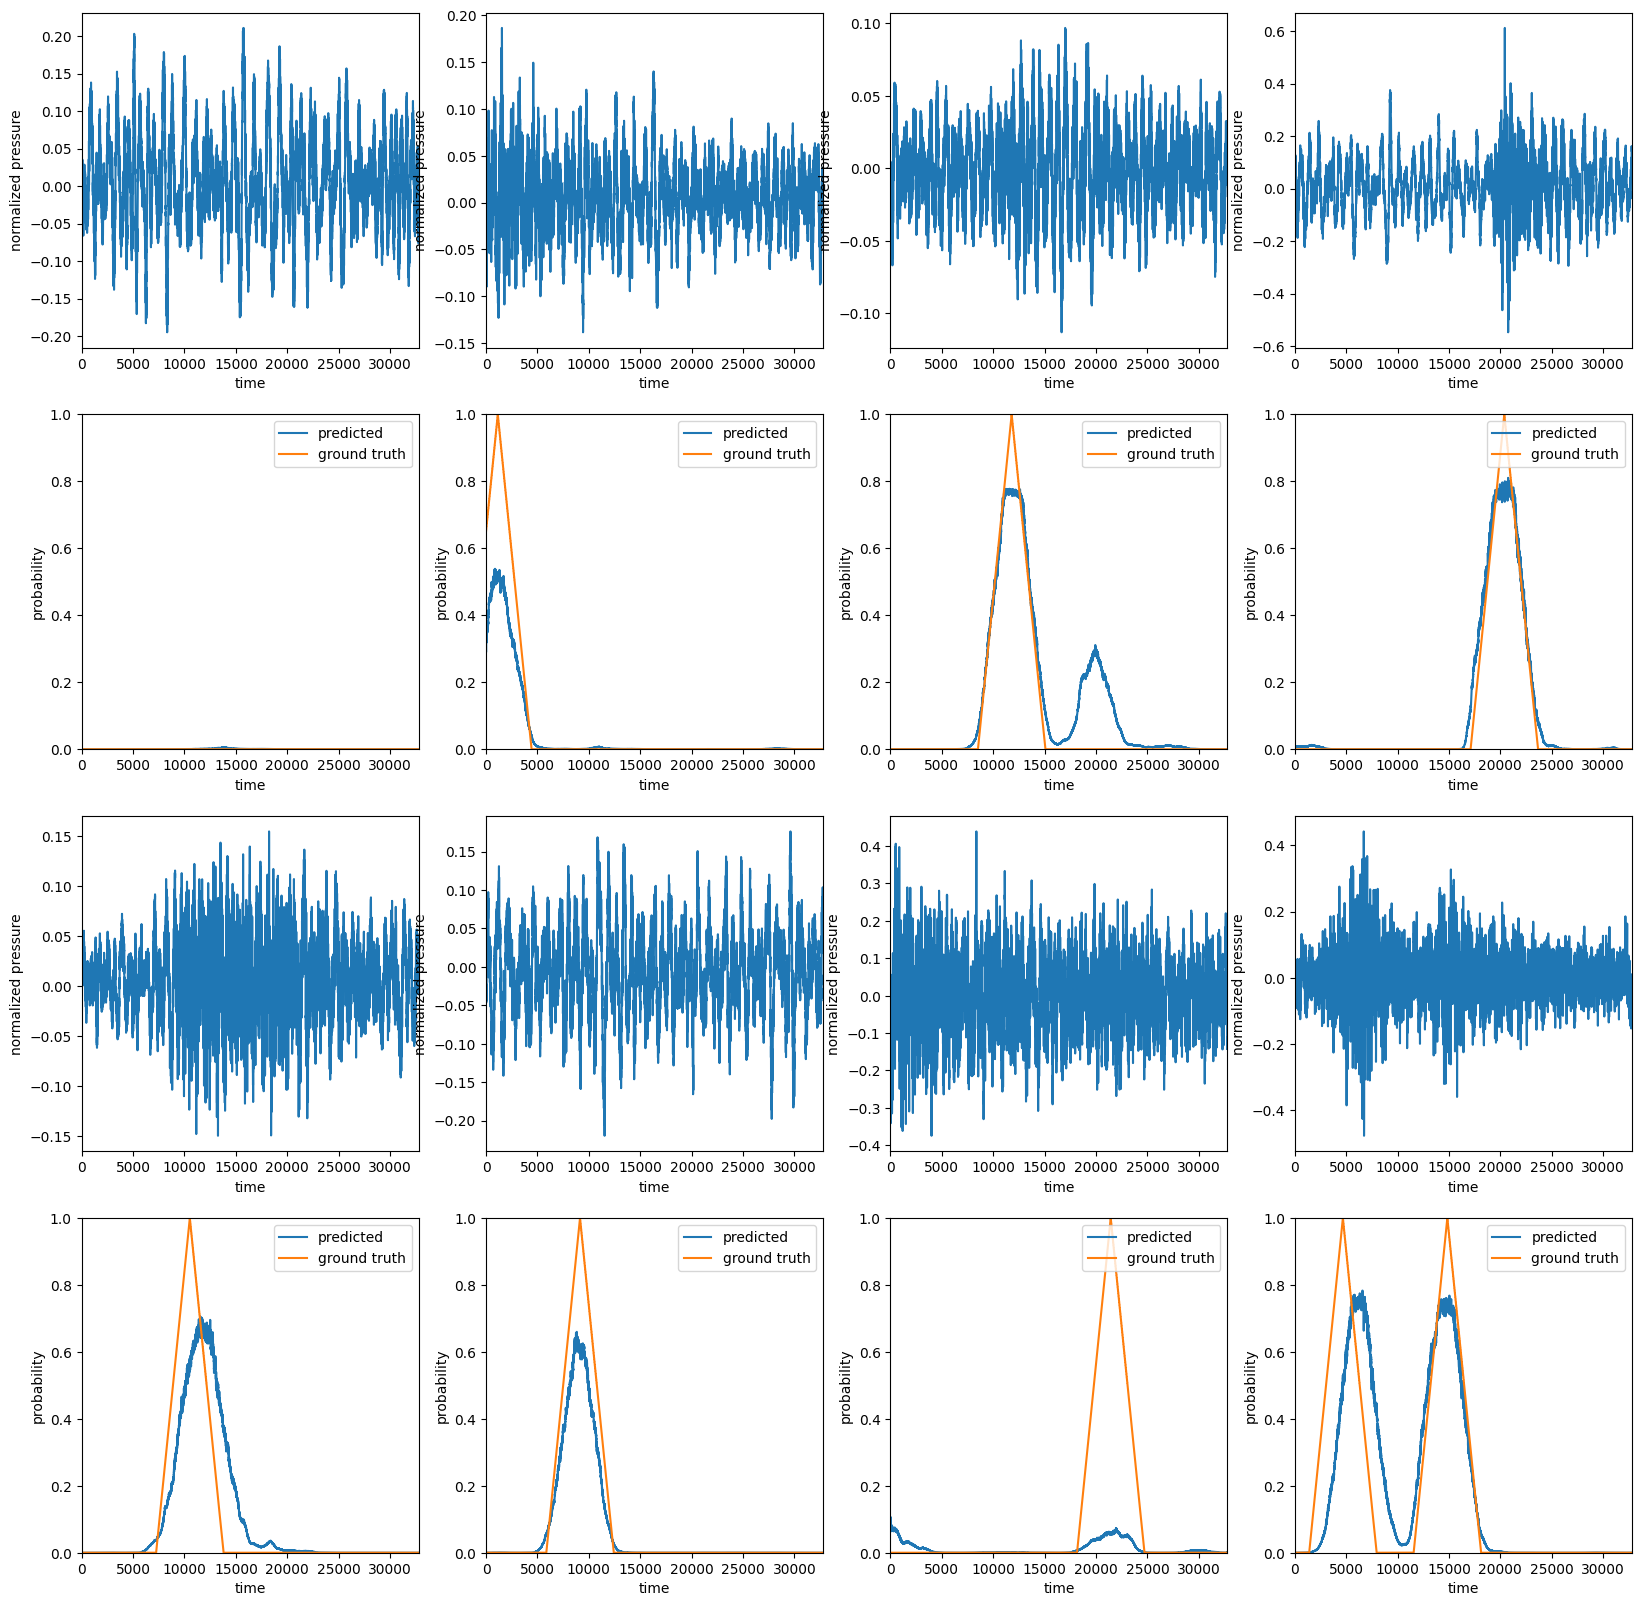

In [5]:
cols = 4
lines = 2
to_skip = 2

to_show = cols * lines
to_skip *= to_show
plt.figure(figsize=(cols*5, lines*10))
shown=0
for i in range(to_skip, to_skip+to_show):
    x, y = xd[i], yd[i]
    
    ax1 = plt.subplot(lines*2, cols, 1 + shown%cols + cols*2*(shown//cols))
    plt.xlabel("time")
    plt.ylabel("normalized pressure")
    plt.plot(x)
    ax1.set_xlim([0, SIZE])

    ax2 = plt.subplot(lines*2, cols, 1 + shown%cols + cols*2*(shown//cols) + cols)
    
    predicted = m.predict(np.reshape(x, (1, SIZE)), verbose=False)[0]
    ax2.plot(predicted, label='predicted')
    ax2.plot(y, label='ground truth')
    ax2.legend(loc="upper right")
    ax2.set_xlim([0, SIZE])
    ax2.set_ylim([0, 1])
    ax2.set_xlabel("time")
    ax2.set_ylabel("probability")

    shown += 1
plt.show()